In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
sldr = widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
print(sldr.value)
sldr

7


IntSlider(value=7, continuous_update=False, description='Test:', max=10)

In [2]:
from matplotlib import pyplot as plt
import copy
import numpy as np
import pandas as pd
import scipy
from scipy.signal import savgol_filter
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import sys
cols = ['chest_acc_x','chest_acc_y','chest_acc_z',
        'chest_mag_x','chest_mag_y','chest_mag_z',
        'chest_gyro_x','chest_gyro_y','chest_gyro_z',
        'arm_acc_x','arm_acc_y','arm_acc_z',
        'arm_mag_x','arm_mag_y','arm_mag_z',
        'arm_gyro_x','arm_gyro_y','arm_gyro_z',
        'leg_acc_x','leg_acc_y','leg_acc_z',
        'leg_mag_x','leg_mag_y','leg_mag_z',
        'leg_gyro_x','leg_gyro_y','leg_gyro_z',
        'chest_quar_w','chest_quar_x','chest_quar_y','chest_quar_z',
        'arm_quar_w','arm_quar_x','arm_quar_y','arm_quar_z',
        'leg_quar_w','leg_quar_x','leg_quar_y','leg_quar_z',
        'class']

ref_cols = ['leg_acc_x','leg_acc_y','leg_acc_z',
            'leg_mag_x','leg_mag_y','leg_mag_z',
            'leg_gyro_x','leg_gyro_y','leg_gyro_z',
            'leg_quar_w','leg_quar_x','leg_quar_y','leg_quar_z']
pth2data = "D:\Dropbox\Ju\EDI\Convergence\CapturedData\EDI-Activity-Database-16-08-2019-Clean\Juris_O1-1564042571.csv"

#"D:\Dropbox\Ju\EDI\Convergence\CapturedData\EDI-Data\Andis-1528983909.csv"  
#"D:\Dropbox\Ju\EDI\Convergence\CapturedData\EDI-Data\Aleksandrs-1528981740.csv" # #


pth2data2 = "D:\Dropbox\Ju\EDI\Convergence\CapturedData\Squats\pietupieni_nepareizi_4_mazs_squat.csv"
pth2ref2 = "D:\Dropbox\Ju\EDI\Convergence\CapturedData\Squats\pietupieni_pareizi_1.csv"

In [3]:
class curve:
    def __init__(self,x,y):
        if(len(x)!=len(y)):
            raise ValueError('x and y must be the same length')
        self.x = np.array(x)
        self.y = np.array(y)
        self.i = 0
        self._data_len = len(self.x)
    def __len__(self):
        return self._data_len
    def __next__(self):
        pass
    def __iter__(self):
        return curve_iterator(self)
class curve_iterator:
    def __init__(self,crv):
        self._curve=crv
        self._index = 0
    def __next__(self):
        if self._index < (len(self._curve.x)):
            result = curve([self._curve.x[self._index]],[self._curve.y[self._index]])
            self._index+=1
            return result
        raise StopIteration

In [4]:
user_raw_data = pd.DataFrame(pd.read_csv(pth2data,header=None,names=cols,index_col=False)[1:])
user_raw_data.loc[:,user_raw_data.columns != 'class'] = user_raw_data.loc[:,user_raw_data.columns != 'class'].astype(float)
ref_data = pd.DataFrame(pd.read_csv('D:\Dropbox\Ju\EDI\Convergence\CapturedData\EDI-Data\hip.running.csv'))
ref_data = curve(np.linspace(0,ref_data['x'].values[-1],
                             100),
                 np.interp(np.linspace(0,ref_data['x'].values[-1],
                                       100),
                           ref_data['x'],
                           ref_data['y']))
np.set_printoptions(threshold=sys.maxsize)

beate = pd.DataFrame(pd.read_csv(pth2data2,header=None,names=ref_cols,index_col=False)[1:])
beate_ref = pd.DataFrame(pd.read_csv(pth2ref2,header=None,names=ref_cols,index_col=False)[1:])
beate = beate.astype(float)
beate_ref = beate_ref.astype(float)

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Our Goal
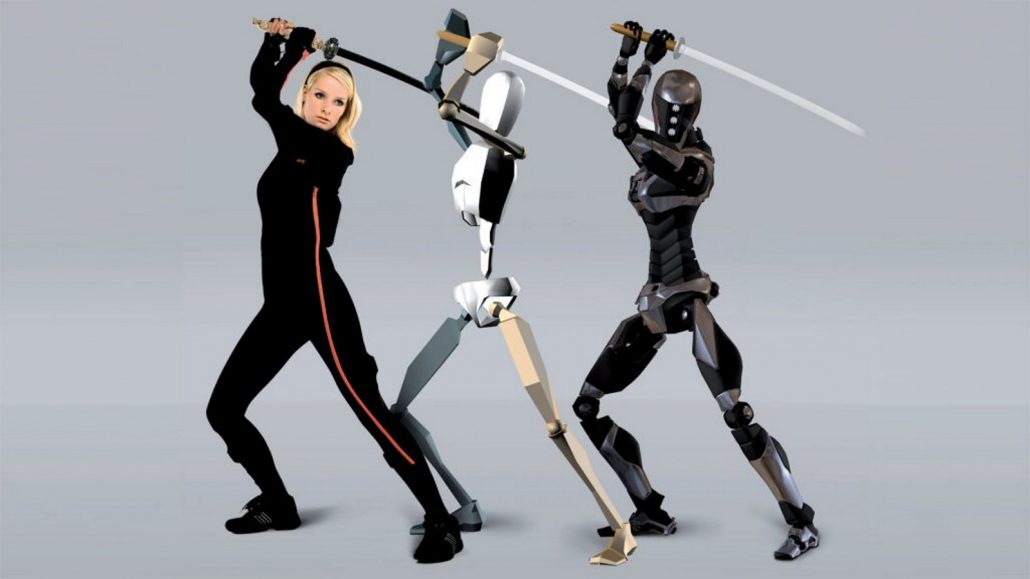

How could we capture or analyze motion?
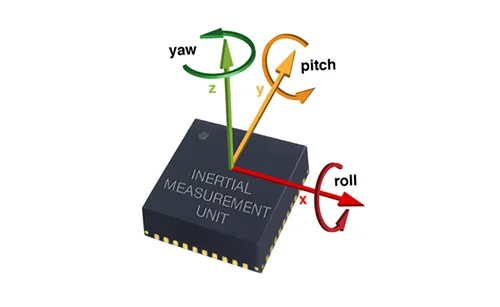

What we want

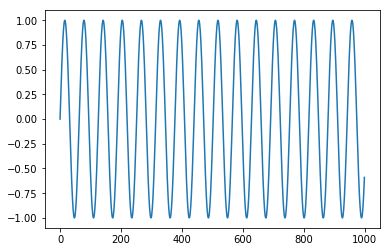

In [5]:
plt.plot(np.sin(np.arange(0,100,0.1)))

What we have

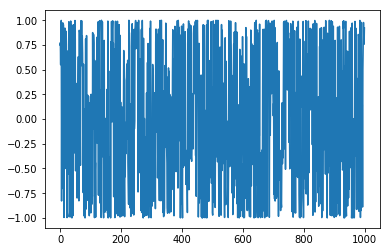

In [6]:
data = (np.sin(np.arange(0,100,0.1)+10*np.random.rand(1,len(np.arange(0,100,0.1)))))
plt.plot(data[0])

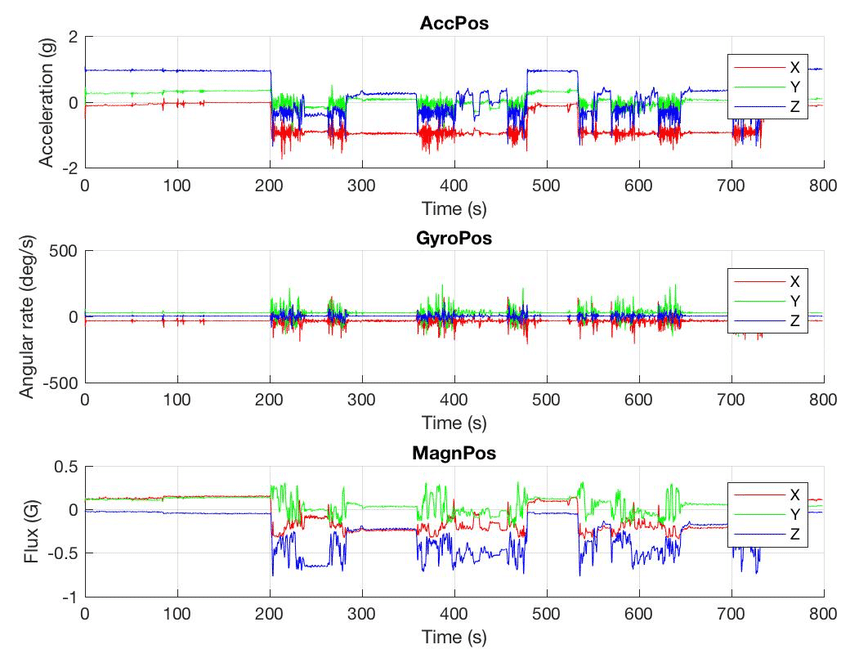

To understan is it possible to compare two motions we need to check the similarity of the two signal

correlation

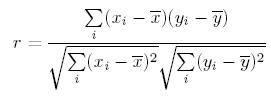

In [7]:
def calc_std(x):
    return np.sqrt(np.sum(np.power(x-np.mean(x),2))/(len(x)-1))

In [8]:
def calc_correl(x,y):
    if(not(len(x) == len(y))):
        return 0
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    #print('x mean = '+str(x_mean)+' y mean = ' + str(y_mean))
    s_x = calc_std(x)
    s_y = calc_std(y)
    #print('x std = '+str(s_x)+' y std = ' + str(s_y))
    z_x = (x-x_mean)/s_x
    z_y = (y-y_mean)/s_y
    #print(('z_x = '+str(z_x)+' z_y = ' + str(z_y)))
    x_y_cov = np.sum(z_x*z_y)
    r = 1/(len(x)-1) * x_y_cov
    return r
    

In [9]:
def norm_by_ref(unnorm_data,unnorm_ref_data):
    unnormalized_data = unnorm_data.copy()
    unnormalized_data = (unnormalized_data - np.nanmin(unnormalized_data))/(np.nanmax(unnorm_ref_data)-np.nanmin(unnorm_ref_data))
    return unnormalized_data

In [10]:
def norm_data(unnorm_data):
    unnormalized_data = unnorm_data.copy()
    unnormalized_data = (unnormalized_data - np.nanmin(unnormalized_data))/(np.nanmax(unnormalized_data)-np.nanmin(unnormalized_data))
    return unnormalized_data

1.0
-0.41036467732879783
[[1. 1.]
 [1. 1.]]
-0.045111264231963655
[[1. 1.]
 [1. 1.]]


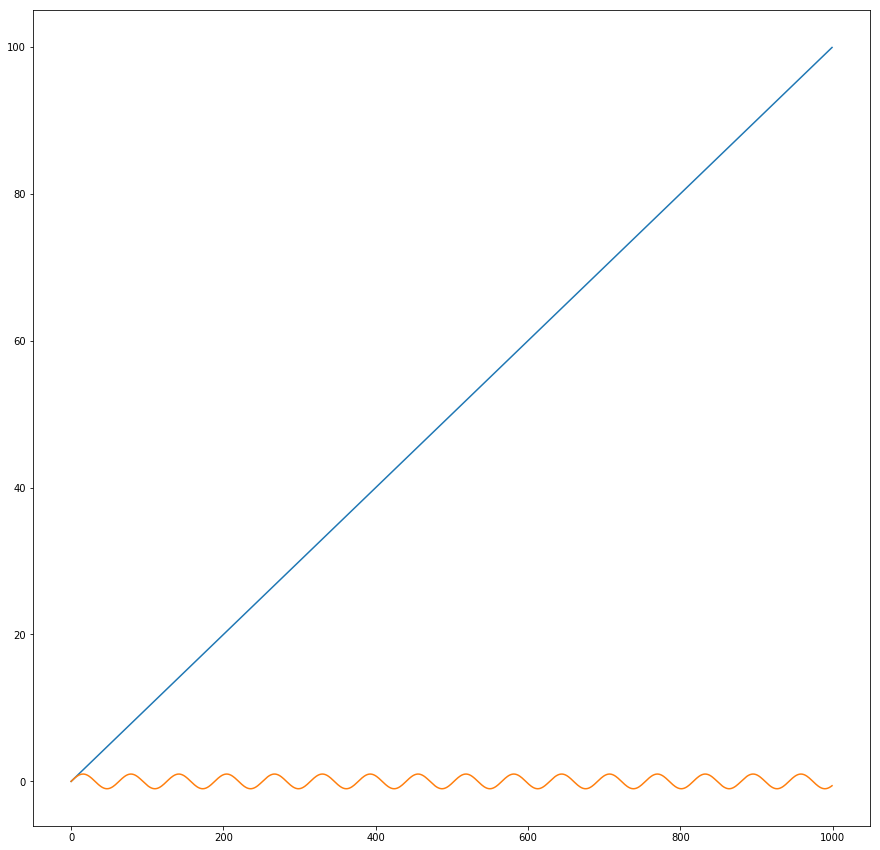

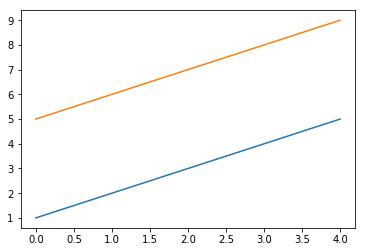

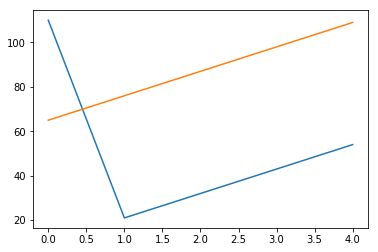

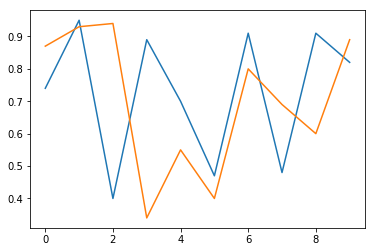

In [11]:
sig1 = np.arange(0,100,0.1)
sig2 = np.sin(sig1)
sig3 = [1,2,3,4,5]
sig4 = [5,6,7,8,9]
sig5 = [110,21,32,43,54]
sig6 = [65,76,87,98,109]
print(calc_correl(sig3,sig4))
print(calc_correl(sig5,sig6))
a =np.array([0.74,0.95,0.40,0.89,0.70,0.47,0.91,0.48,0.91,0.82])
b = np.array([0.87,0.93,0.94,0.34,0.55,0.40,0.80,0.69,0.6,0.89])
calc_correl(a,b)
plt.figure(figsize=(15,15))
plt.plot(sig1)
plt.plot(sig2)
print(np.corrcoef(sig3,sig4))
plt.figure()
plt.plot(sig3)
plt.plot(sig4)
plt.figure()
plt.plot(sig5)
plt.plot(sig6)
plt.figure()
plt.plot(a)
plt.plot(b)
print(calc_correl(sig1,sig2))

print(np.corrcoef(sig3,sig4))
sig3 = norm_by_ref(sig3,sig4)
sig4 = norm_data(sig4)


In [12]:
calc_correl(sig3,sig4)

1.0

Leg acceleration data

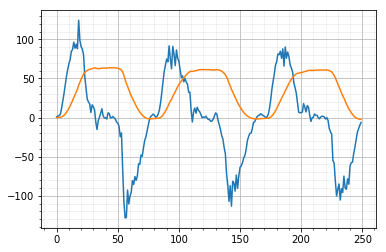

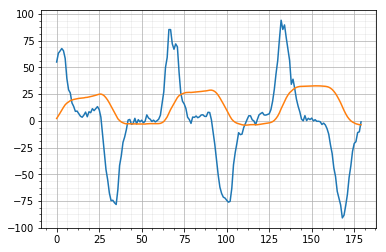

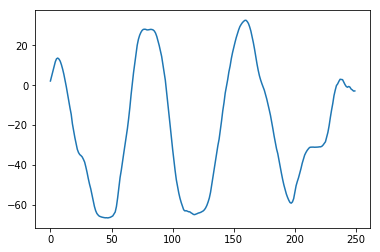

In [13]:
#plt.figure(figsize=(15,15))
#plt.plot(user_raw_data['leg_gyro_z'])
#plt.figure(figsize=(15,15))
#plt.plot(ref_data.x,ref_data.y)
#plt.figure(figsize=(15,15))
#plt.plot(beate['leg_gyro_z'])
#plt.figure(figsize=(15,15))
major_ticks = np.arange(0, 101, 20)
minor_ticks = np.arange(0, 101, 5)
plt.plot(beate_ref['leg_gyro_x'][120:370].values)
plt.plot(np.cumsum(beate_ref['leg_gyro_x'][120:370].values)/25)
plt.minorticks_on()
plt.grid(which='minor',alpha = 0.2)
plt.grid(which='major',alpha = 0.9)
plt.figure()
plt.minorticks_on()
plt.plot(-beate['leg_gyro_x'][130:310].values)
plt.plot(np.cumsum(-beate['leg_gyro_x'][130:310].values)/25)
plt.grid(which='minor',alpha = 0.2)
plt.grid(which='major',alpha = 0.9)
#plt.plot(beate_ref['leg_gyro_y'])
#plt.plot(beate['leg_gyro_y'])
#plt.figure()
#plt.plot(beate_ref['leg_gyro_z'])
plt.figure()
plt.plot(np.cumsum(-beate['leg_gyro_x'][130:380].values)/25 - np.cumsum(beate_ref['leg_gyro_x'][120:370].values)/25)

In [14]:
def auto_correlation_circ(data):
    auto_correlation = np.empty(0)
    for i in range(0,data.size):
        auto_correlation = np.append(auto_correlation,np.correlate(data,np.roll(data,-i),'valid'))
    return auto_correlation

def strech_signal(signal,final_length):
    return np.interp(np.linspace(0,signal.size,final_length),np.arange(0,signal.size),signal)

def strech_array(array,final_length):
    new_array = np.empty(final_length)
    new_array = new_array.reshape(1,new_array.size)
    for signal in np.transpose(array):
        signal = strech_signal(signal,final_length)
        new_array = np.vstack([new_array,signal])
    return new_array

def movement_separetion(raw_movement_data):
    auto_corr = auto_correlation(raw_movement_data)
    peaks,_ = scipy.signal.find_peaks(auto_corr)
    movements = np.empty(len(raw_movement_data[peaks[1]:peaks[2]]))
    movements = movements.reshape(1,movements.size)
    for i in np.arange(1,peaks.size-1):
        print(i)
        if(peaks[i+1]-peaks[i] == movements.shape[1]):
            print('equal')
            movements = np.vstack([movements,raw_movement_data[peaks[i]:peaks[i+1]]])
        elif(peaks[i+1]-peaks[i] > movements.shape[1]):
            print('bigger')
            movements = strech_array(movements,peaks[i+1]-peaks[i])
            movements = np.vstack([movements,raw_movement_data[peaks[i]:peaks[i+1]]])
        elif(peaks[i+1]-peaks[i] < movements.shape[1]):
            print('smaller')
            streched_data = strech_signal(raw_movement_data[peaks[i]:peaks[i+1]],peaks[i+1]-peaks[i])
            movements = np.vstack([movements,streched_data])
        print(movements.shape)
    return movements

def moving_average(data,window):
    aver = np.zeros(window)
    for i in range(0,data.size-window):
        aver = np.append(aver,np.mean(data[i:i+window]))
    return aver 

def sign_change(data):
    return (np.sign(data) - np.roll(np.sign(data),1))

In [15]:
corr = auto_correlation_circ(norm_data(user_activity_angles - moving_average(user_activity_angles,50)))
diff_corr = np.diff(corr)
mask = sign_change(diff_corr)<=0
mask = np.append(False,mask)
plt.plot(corr-min(corr))
plt.plot(np.diff(corr))
print(mask.size)
print(corr.size)
print(user_activity_angles.size)


NameError: name 'user_activity_angles' is not defined

In [16]:
pre_prop_data = user_activity_angles - moving_average(user_activity_angles,50)
pre_prop_data -= np.mean(pre_prop_data)
pre_prop_data = np.interp(np.linspace(0,pre_prop_data.size,pre_prop_data.size*3),np.arange(0,pre_prop_data.size),pre_prop_data)
corr = auto_correlation_circ(norm_data(pre_prop_data))
diff_corr = np.diff(corr)
mask = sign_change(diff_corr)!=0
mask = np.append(False,mask)
plt.plot(pre_prop_data,'.b')

#plt.plot(user_activity_angles)
plt.plot(np.arange(0,pre_prop_data.size)[mask],pre_prop_data[mask],'rx')
plt.grid()


NameError: name 'user_activity_angles' is not defined

In [17]:
plt.figure(figsize=(100,100))
pre_prop_curve = curve(np.arange(0,pre_prop_data.size),norm_data(pre_prop_data))
plt.imshow(np.abs(dtw_matrix(pre_prop_curve,norm_ref_data)))
#plt.ylim([0,500])

NameError: name 'pre_prop_data' is not defined

<Figure size 7200x7200 with 0 Axes>

In [18]:
def f(a, b):
    plt.figure(2)
    plt.plot(pre_prop_data,'.b')
    plt.plot(np.arange(0,pre_prop_data.size)[mask],pre_prop_data[mask],'rx')
    b = a+b
    plt.xlim([a,b])
    plt.grid()
    plt.show()
    

interactive_plot = interactive(f, a=(0, 20000), b=(0, 2000))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=10000, description='a', max=20000), IntSlider(value=1000, description='b…

<Figure size 432x288 with 0 Axes>

In [19]:
movement_separetion(trainer_angle_data)

NameError: name 'trainer_angle_data' is not defined

In [20]:
trainer_angle_data = np.cumsum(-beate['leg_gyro_x'].values)/25
auto_corr = auto_correlation(trainer_angle_data)
a,_ = scipy.signal.find_peaks(auto_corr)
plt.plot(y_)
print(a,b)
plt.figure()
for i in np.arange(1,a.size-1):
    #plt.plot(a,y_[a],'rx')
    plt.plot(trainer_angle_data[a[i]:a[i+1]])
#plt.xlim([0,len(beate)])

NameError: name 'auto_correlation' is not defined

In [21]:
y_.size

NameError: name 'y_' is not defined

In [22]:
def interpol(y,new_size):
    new_x = np.linspace(0,len(y)-1,new_size)
    old_x = np.arange(0,len(y))
    new_array = np.empty([0])
    i=0
    for x in new_x:
        if old_x[i+1]<x:
            i+=1
        if i>=(len(y)-1):
            break
        new_array = np.append(new_array,y[i]+(y[i+1]-y[i])*((x-old_x[i])/(old_x[i+1]-old_x[i])))
    return new_array

In [23]:
def eucl_dist(res_point,ref_curve):
    distances = np.empty(0)
    for point in ref_curve:
        dist = np.sqrt(np.power(res_point.x-point.x,2)+np.power(res_point.y-point.y,2))
        distances = np.append(distances,dist)
    return distances

In [32]:
def dtw_matrix(user,ref):
    dtw = np.empty([len(user),len(ref)])
    for i in range(0,len(user)):
        for j in range(0,len(ref)):
            dtw[i,j] = ref.y[j] - user.y[i]
    return dtw


100 66


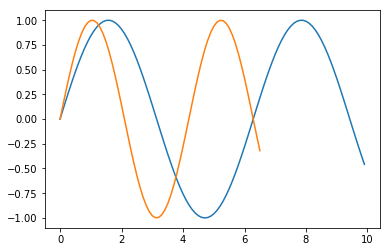

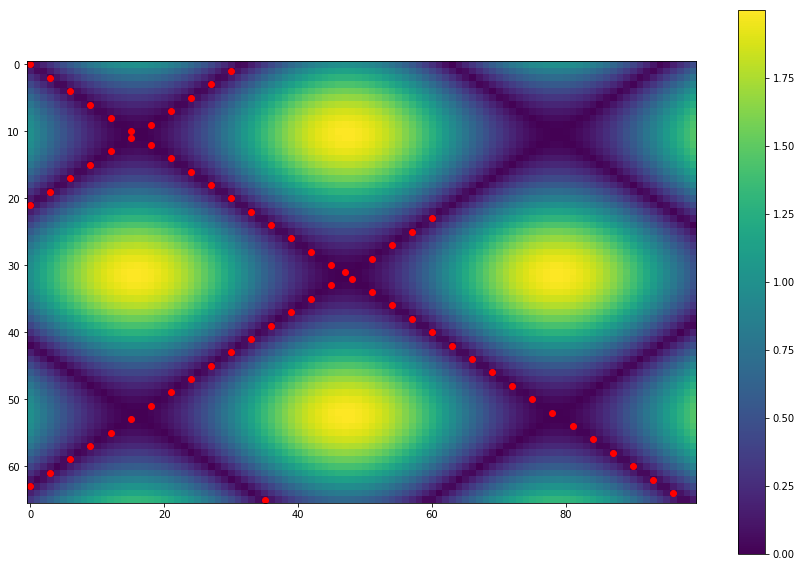

In [36]:

x1 = np.arange(0,10,0.1)
x2 = np.arange(0,6.6,0.1)
ref = curve(x1,np.sin(x1))
user = curve(x2,np.sin(1.5 * x2))

plt.plot(ref.x,ref.y)
plt.plot(user.x,user.y)


dtw = np.abs(dtw_matrix(user,ref))
#np.where(dtw==0)

plt.figure(figsize=(15,10))
plt.imshow(dtw)
plt.colorbar()
i = 0
for line in dtw:
    plt.plot(np.argmin(np.abs(line)),i,'ro')
    i+=1
print(len(ref),len(user))

In [39]:
new_arr = np.empty([0])
dtw_points = np.where(dtw==0)
print(dtw_points)
for i in range(0,len(dtw_points[1])-1):
    interp_segment = user.y[int(dtw_points[1][i]):int(dtw_points[1][i+1]+1)]
    print(dtw_points[0][i+1] - dtw_points[0][i]+1)
    interp_result = interpol(interp_segment,dtw_points[0][i+1] - dtw_points[0][i]+1)
    new_arr = np.append(new_arr,interp_result[0:-1])

(array([ 0,  2,  4,  8, 10, 12, 14, 16, 18, 20, 22, 26, 28, 30, 32, 34, 36,
       38, 40, 42, 44, 46, 50, 52, 56, 58, 60, 62, 64], dtype=int64), array([ 0,  3,  6, 12, 15, 18, 21, 24, 27, 30, 33, 39, 42, 45, 48, 51, 54,
       57, 60, 63, 66, 69, 75, 78, 84, 87, 90, 93, 96], dtype=int64))
3
3
5
3
3
3
3
3
3
3
5
3
3
3
3
3
3
3
3
3
3


IndexError: index 1 is out of bounds for axis 0 with size 0

ValueError: operands could not be broadcast together with shapes (44,) (64,) 

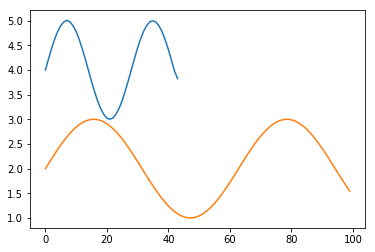

In [27]:
plt.plot(new_arr+4)
plt.plot(ref.y+2)
plt.plot(new_arr-ref.y[0:dtw_points[0][-1]])
plt.grid()

In [28]:
ref_dat_len = 100
win = 10


user_activity = (user_raw_data[user_raw_data['class'] == 'Running']['leg_gyro_z'].values)*(180/np.pi)
#alex_max_val = np.max(alex_running)
#alex_running = savgol_filter(alex[alex['class'] == 'Running']['leg_gyro_z'].values,17,3)
#alex_running = norm_data(alex_running)*alex_max_val
user_activity_angles = np.array([0])
for dot in user_activity:
    user_activity_angles = np.append(user_activity_angles,(user_activity_angles[-1]+dot/25))

user_activity_angles = user_activity_angles - moving_average(user_activity_angles,win)
norm_user_activity_angles = curve(np.arange(0,len(user_activity_angles)),(user_activity_angles - np.min(user_activity_angles))/(np.max(user_activity_angles) - np.min(user_activity_angles)))
norm_ref_data = curve(ref_data.x,(ref_data.y - np.min(ref_data.y))/(np.max(ref_data.y) - np.min(ref_data.y)))
norm_ref_data.y = np.interp(np.arange(0,len(norm_ref_data),len(norm_ref_data)/ref_dat_len),np.arange(0,len(norm_ref_data)),norm_ref_data.y)


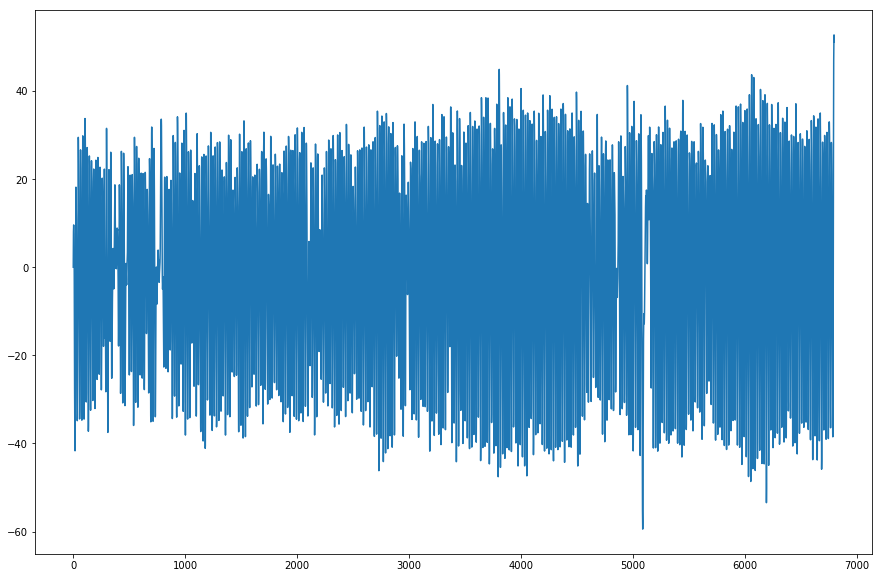

In [27]:

conv = norm_data(scipy.signal.fftconvolve(user_activity_angles,user_activity_angles,'full')[:len(user_activity_angles)])
pk,_ = scipy.signal.find_peaks(-conv)

plt.figure(figsize=(15,10))
plt.plot(user_activity_angles)
#for i in pk:
#    plt.plot([i,i],[np.min(user_activity_angles),np.max(user_activity_angles)],'y')
#    pass
#plt.plot(user_activity_angles)
#plt.plot((ref_data.y-np.mean(ref_data.y)))#*(np.pi/180))


#plt.xlim([2000,3000])
#plt.ylim([0,0.01])


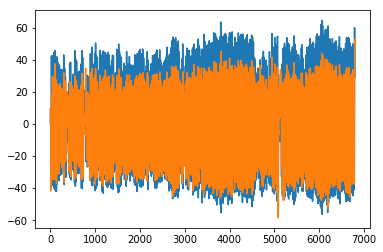

In [28]:
 
win = 10
plt.plot(user_activity_angles - moving_average(user_activity_angles,win))
#plt.xlim([0,900])
win = 100
plt.plot(user_activity_angles - moving_average(user_activity_angles,win))
#plt.xlim([0,900])

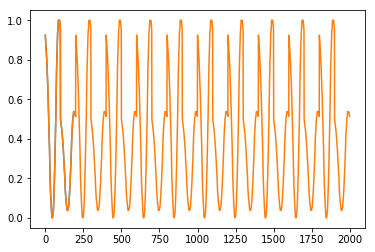

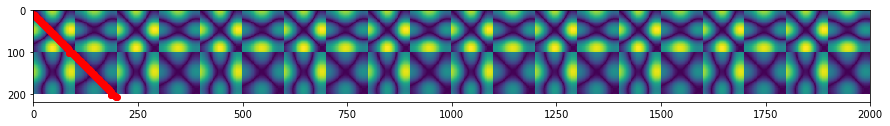

In [29]:
test_ref_data = norm_data(np.append(ref_data.y,ref_data.y/2))
test_user_data = np.empty(0)
for i in range(0,10):
    test_user_data = np.append(test_user_data,test_ref_data)
test_ref_data = curve(np.arange(0,test_ref_data.size),test_ref_data)
test_user_data = curve(np.arange(0,test_user_data.size),test_user_data)
#test_user_data.y += np.random.rand(test_user_data.y.size)
plt.plot(test_ref_data.y)
plt.plot(test_user_data.y)

plt.figure(figsize=(15,10))
dtw = dtw_matrix(test_user_data,test_ref_data)
plt.imshow(dtw)
for line in dtw:
    plt.plot(np.argmin(np.abs(line)),i,'ro')
    i+=1
#plt.xlim([0,250])

In [30]:
 def find_signal_start(dtw_mtrx,strt):
    i = 0
    min_diff = np.inf
    indx = 0
    for i in range(strt,len(dtw_mtrx[0,:])-1):
        if(dtw_mtrx[0,i] - dtw_mtrx[0,i+1] < 0):
            indx = i
            return indx
        i+=1
    return -1
def find_signal_end(dtw_mtrx,strt):
    i = 0
    min_diff = np.inf
    indx = 0
    for i in range(strt,len(dtw_mtrx[0,:])-1):
        if(dtw_mtrx[0,i] - dtw_mtrx[0,i+1] > 0):
            indx = i
            return indx
        i+=1
    return -1
def find_start_and_end(dtw_mat,start):
    start = find_signal_start(dtw_mat,start)
    end = find_signal_start(dtw_mat,find_signal_end(dtw_mat,start))+1
    return start,end

def find_end_of_step(sep_stp):
    for i in range(0,len(sep_stp)-1):
        if((sep_stp[i] == 0) and (sep_stp[i+1] == 0)):
            return i
    return i

In [31]:
def find_path(mat,stop_at_rows_end=False,stop_at_collumns_end=False):
    temp = np.ones([mat.shape[0]+1,mat.shape[1]+1])*np.inf
    temp[:-1,:-1] = mat
    mat = temp
    path = np.array([[0,0,mat[0,0]]])
    i = 0 #rows
    j = 0 #collumns
    cont_cond = True
    while (cont_cond):
        
        neighbors = [mat[i+1,j+1],
                     mat[i+1,j],
                     mat[i,j+1]]
        arg = np.argmin(neighbors)
        if(arg == 0) or (neighbors[0] == neighbors[1] == neighbors[2]):
            j+=1
            i+=1
        elif(arg == 1):
            i+=1
        elif(arg == 2):
            j+=1
            
        
        cont_cond = (i < mat[:,0].size-2) and (j < mat[0,:].size-2)
        """ 
        if(i>=mat[:,0].size-1):
            i-=1
        if(j>=mat[0,:].size-1):
            j-=1
        """
        if mat[i,j] < np.inf:
            new_point = [i,j,mat[i,j]]
            path = np.vstack([path,new_point])
    return path

In [32]:
def separate_moves(user_data,norm_user_data,reference_data):
    dtw_mat = dtw_matrix(norm_user_data,reference_data)
    start = 0
    end = 1
    sp_stps = np.ones([1,50]) * np.nan
    nan_arr = np.ones([1,50]) * np.nan
    while (start >= 0) and (end > 0) and (start <= end):
        start, end = find_start_and_end(dtw_mat,end)
        #print(sp_stps.shape,nan_arr.shape)
        if (start >= 0) and (end > 0) and (start <= end) :
            for i in range(start,end+1):
                sp_stps[-1,i-start] = user_data[i]
        else:
            break
        sp_stps = np.vstack([sp_stps,nan_arr])
    return sp_stps[:-1]

In [33]:
plt.imshow(dtw[new_y:,:])

NameError: name 'new_y' is not defined

In [ ]:
import time

#plt.figure(figsize=(100,100))
a = curve(norm_user_activity_angles.x,norm_data(norm_user_activity_angles.y))
b = norm_ref_data
plt.figure(0,figsize=(100,100))
start = time.time()
dtw = dtw_matrix(a,b)
plt.imshow(dtw)
plt.figure(1,figsize=(100,100))
plt.plot(a.y)
plt.plot(b.y)
new_y = 0
pth_ = np.array([[0],[0],[0]])
while(new_y<len(a)-1):
    plt.figure(0)
    new_y += int(pth_[-1,0])
    pth_ = find_path(dtw[new_y:,:])
    plt.plot(pth_[:,1],pth_[:,0]+new_y,'ro')
    plt.figure(1)
    plt.plot([new_y,new_y],[0,1])
    #print(new_y)

end = time.time()
print(end - start)

KeyboardInterrupt: 

In [ ]:
#plt.figure(figsize=(100,100))
plt.imshow(np.abs(dtw_matrix(curve(norm_user_activity_angles.x[:50],norm_user_activity_angles.y[:50]),norm_ref_data)))
pth_mat = find_path(np.abs(dtw_matrix(curve(norm_user_activity_angles.x[:50],norm_user_activity_angles.y[:50]),norm_ref_data)))
#plt.plot(pth_mat[:,0],pth_mat[:,1])
#plt.xlim([0,100])
sep_steps = separate_moves(user_activity_angles,norm_user_activity_angles,norm_ref_data)
#sep_steps = separate_moves(user.y,curve(user.x,norm_data(user.y)),norm_ref_data)


In [ ]:
for i in range(0,len(sep_steps)):
    sep_steps[i][:] -= np.nanmean(sep_steps[i][:])
    plt.plot(sep_steps[i][:])


In [ ]:
def stretching(user_data,reference_data,path):
    uni, counts = np.unique(path[:,1], return_counts=True)
    uni = np.append(uni,uni[-1]+1)
    counts[0]+=2
    counts = np.append(counts,0)
    new_x = np.empty([0])
    for i in np.arange(uni[0],uni[-1],dtype=np.int):
        #if counts[i] > 1:
        x_section = np.linspace(uni[i],uni[i+1],counts[i]+1)[:-1]
        new_x = np.append(new_x,x_section)
        #elif counts[i] == 1 and i > 1:
        #    x_section = new_x[-1] + (new_x[-1] - new_x[-2]) * 1.5
        #    new_x[-1]  += (new_x[-1] - new_x[-2]) * 0.5
        #else:
        #    pass        
    #len_x = len(new_x)
    #if (len(reference_data)-len(new_x))>0:
    #    new_x = np.append(new_x,np.linspace(new_x[-1],len(reference_data),len(reference_data)-len(new_x)))
    #new_x = new_x[:len(reference_data)]
    print(new_x[0],new_x[-1],user_data.x[0],user_data.x[-1])
    new_y = np.interp(new_x,user_data.x,user_data.y)#,period = len(reference_data))
    new_user = curve(new_x,new_y)

    new_ref = curve(new_x,new_y)
    return new_user,new_ref

In [34]:
def stretching(user_data,reference_data,path):
    streched_reference_data = np.interp(np.array(path)[:,0],np.arange(0,len(reference_data)),reference_data.y)
    streched_reference_data -= np.min(streched_reference_data)
    streched_user_data = np.interp(np.array(path)[:,1],np.arange(0,len(user_data)),user_data.y)
    streched_user_data -= np.min(streched_user_data)
    return curve(np.array(path)[:,1],streched_user_data),curve(np.array(path)[:,0],streched_reference_data)

In [35]:
def time_to_excercise_domain(user_data,reference_data):
    user_data.y -= np.nanmin(user_data.y)
    pth = find_path(np.abs(dtw_matrix(copy.copy(user_data),copy.copy(reference_data))))
    streched_y = stretching(user_data,reference_data,pth)
    return streched_y

In [36]:
def time_to_excercise_domain(user_data,reference_data):
    dist,path = fastdtw(reference_data.y-np.mean(reference_data.y),user_data.y)
    user,ref = stretching(copy.copy(user_data),copy.copy(reference_data),path)
    return user,ref

In [37]:
i = 0

for stp in sep_steps:
    stp = stp[np.logical_not(np.isnan(stp))]
    stp_x = np.linspace(0,len(stp),len(ref_data))
    stp_y = np.interp(stp_x,np.arange(0,len(stp)),stp)
    stp = curve(stp_x,stp_y)
    #stp.y = stp.y-min(stp.y)
    
    processed_data,new_ref_data = time_to_excercise_domain(copy.copy(stp),copy.copy(ref_data))
    plt.figure()
    #plt.plot(stp.y)
    plt.plot(new_ref_data.y,'r')
    plt.plot(processed_data.y,'g')
    i+=1
    if(i>5):
        pass
        break 

NameError: name 'sep_steps' is not defined

In [ ]:
import numpy as np

def KL(P,Q):
    """ Epsilon is used here to avoid conditional code for checking that neither P nor Q is equal to 0. """
    epsilon = 0.00001
    # You may want to instead make copies to avoid changing the np arrays.
    P = P+epsilon
    Q = Q+epsilon
    divergence = np.sum(P*np.log(P/Q))
    return divergence

# Should be normalized though
values1 = norm_by_ref(stp.y,ref_data.y)
values2 = norm_data(ref_data.y)
print(len(values1),len(values2))
# Note slight difference in the final result compared to Dawny33
print (KL(values1, values2)) # 0.775278939433